## Find beamline optical functions interactively using [Elegant](https://ops.aps.anl.gov/manuals/elegant_latest/elegant.html)

[A. Petrenko](https://www.inp.nsk.su/~petrenko/) (Novosibirsk, 2023)

In [1]:
import numpy as np
import pandas as pd
import os
import glob
from io import StringIO

<a href=https://ops.aps.anl.gov/manuals/elegant_latest/elegant.html>Elegant</a> lattice file:

In [2]:
with open("machine.lte", "r") as f:
    print(f.read())

D10 : DRIFT, L=1.0

Q10  : QUAD,  L=0.2, K1=-3
DQ10 : DRIFT, L=0.3
Q20  : QUAD,  L=0.2, K1=5
DQ20 : DRIFT, L=0.3
Q30  : QUAD,  L=0.2, K1=-2.5

Triplet10 : LINE=(Q10,DQ10,Q20,DQ20,Q30)

D20 : DRIFT, L=0.5

B10: SBEND, L=0.8, angle=0.35
DB10: DRIFT, L=1.0
QdogF: QUAD, L=0.2, K1=+3
DQdogF: DRIFT, L=1.0
QdogD: QUAD, L=0.2, K1=-1
B20: B10, angle=-0.35

DOGLEG : LINE=(B10,DB10,QdogF,DQdogF,QdogD,DQdogF,QdogF,DB10,B20)

D30 : DRIFT, L=0.5

Q40  : QUAD,  L=0.2, K1=-3
DQ40 : DRIFT, L=0.3
Q50  : QUAD,  L=0.2, K1=5
DQ50 : DRIFT, L=0.3
Q60  : QUAD,  L=0.2, K1=-2.5

Triplet20 : LINE=(Q40,DQ40,Q50,DQ50,Q60)

DFF : DRIFT, L=2.0

machine : LINE=(D10,Triplet10,D20,DOGLEG,D30,Triplet20,DFF)


In [3]:
with open("twiss.ele", "r") as f:
    print(f.read())

&divide_elements
    name = *
    maximum_length = 0.05
&end

&run_setup
    lattice = machine.lte
    magnets = results/beamline.mag
    parameters = results/beamline.par
    p_central_mev = 100.0
    use_beamline = machine
&end

&load_parameters
    filename = parameters2load.sdds
    change_defined_values = 1
    verbose = 1
    allow_missing_files = 1  
&end

&twiss_output
    filename = results/twiss.twi
    matched = 0
    beta_x  =  30.0
    beta_y  =  30.0
&end

&run_control &end

&bunched_beam &end

&track &end

!back_tracking:

&run_setup
    lattice = machine.lte
    p_central_mev = 100.0
    use_beamline = machine
    back_tracking = 1
&end

&load_parameters
    filename = parameters2load.sdds
    change_defined_values = 1
    verbose = 1
    allow_missing_files = 1  
&end

&twiss_output
    filename = results/twiss_backwards.twi
    matched = 0
    beta_x  =  0.2
    beta_y  =  0.2
&end

&run_control &end

&bunched_beam &end

&track &end



Empty the 'results/' folder:

In [4]:
if not os.path.exists("results/"): os.mkdir("results/")
# empty the "results" folder:
for f in glob.glob('results/*'): os.remove(f)

Run Elegant

In [5]:
%time
out = !elegant twiss.ele
print("\n".join(out[-10:]))

CPU times: user 6 μs, sys: 1e+03 ns, total: 7 μs
Wall time: 13.8 μs

Finished tracking.
End of input data encountered.
statistics:    ET:  00:00:0.076 CP:    0.06 BIO:0 DIO:0 PF:0 MEM:7414
Thanks for using elegant.  Please cite the following reference in your publications:
  M. Borland, "elegant: A Flexible SDDS-Compliant Code for Accelerator Simulation,"
  Advanced Photon Source LS-287, September 2000.
If you use a modified version, please indicate this in all publications.


In [6]:
# read SDDS-file into pandas dataframe
def sdds2df(sdds_file, columns="all"):
    if columns=="all":
        columns = !sddsquery $sdds_file -columnlist
    col_str = "-col=" + ",".join(columns)
    out = !sdds2stream $sdds_file $col_str -pipe=out
    DATA = StringIO("\n".join(out))
    df = pd.read_csv(DATA, names=columns, sep=r'\s+')
    return df

In [7]:
df_mag = sdds2df('results/beamline.mag')

In [8]:
df_mag.tail(3)

,ElementName,ElementType,s,Profile
806,DFF,DRIF,12.55,0.0
807,DFF,DRIF,12.55,0.0
808,DFF,DRIF,12.60,0.0


In [9]:
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [10]:
pio.templates.default = pio.templates["simple_white"]

In [11]:
mag = go.Scatter(
    x=df_mag.s, y=df_mag.Profile, mode='lines', line_width=2, line_color="gray",
    hovertext=df_mag.ElementName, hoverinfo="text", showlegend=False
)

Reading Twiss output table:

In [12]:
df = sdds2df('results/twiss.twi')
df.tail(3)

,s,betax,alphax,psix,etax,etaxp,xAperture,betay,alphay,psiy,etay,etayp,yAperture,pCentral0,ElementName,ElementOccurence,ElementType,ChamberShape
250,12.50,5305.286126,-1743.020732,6.405294,-0.069750,-0.022518,10.0,60.490975,-87.385705,4.326396,0.0,0.0,10.0,195.695076,DFF,38,DRIF,?
251,12.55,5481.019848,-1771.653705,6.405303,-0.070876,-0.022518,10.0,69.545182,-93.698433,4.327167,0.0,0.0,10.0,195.695076,DFF,39,DRIF,?
252,12.60,5659.616867,-1800.286678,6.405312,-0.072002,-0.022518,10.0,79.230661,-100.011161,4.327840,0.0,0.0,10.0,195.695076,DFF,40,DRIF,?


In [13]:
dfback = sdds2df('results/twiss_backwards.twi')
dfback.tail(3)

,s,betax,alphax,psix,etax,etaxp,xAperture,betay,alphay,psiy,etay,etayp,yAperture,pCentral0,ElementName,ElementOccurence,ElementType,ChamberShape
250,0.10,11972.797566,3342.303138,-7.790154,0.024029,-0.005234,10.0,10838.953153,146.160313,-4.464131,0.0,0.0,10.0,195.695076,D10,3,DRIF,?
251,0.05,12309.360457,3388.954688,-7.790158,0.024291,-0.005234,10.0,10853.574112,146.258865,-4.464136,0.0,0.0,10.0,195.695076,D10,2,DRIF,?
252,0.00,12650.588504,3435.606237,-7.790162,0.024553,-0.005234,10.0,10868.204926,146.357416,-4.464140,0.0,0.0,10.0,195.695076,D10,1,DRIF,?


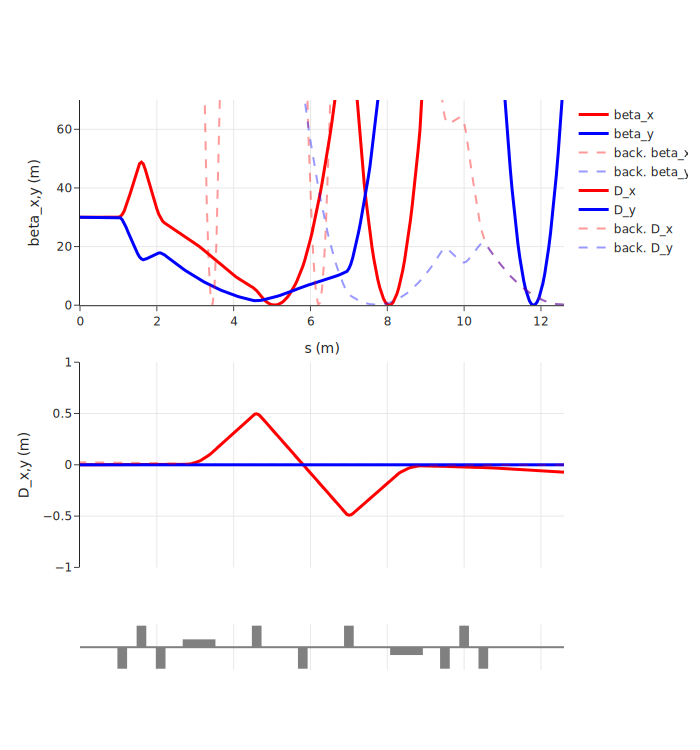

In [14]:
fig = make_subplots(rows=3, shared_xaxes=True, row_heights=[0.9/2, 0.9/2, 0.1])

fw = go.FigureWidget(fig)

fw.add_trace( go.Scatter(x=df.s, y=df.betax, mode='lines', line={'width':3, "color":"red"},  name='beta_x'), row=1, col=1 ) # 0
fw.add_trace( go.Scatter(x=df.s, y=df.betay, mode='lines', line={'width':3, "color":"blue"}, name='beta_y'), row=1, col=1 ) # 1

fw.add_trace( go.Scatter(x=dfback.s, y=dfback.betax, mode='lines',
                         line={'width':2, "color":"red", "dash":"dash"},  opacity=0.4, name='back. beta_x'), row=1, col=1 ) # 2
fw.add_trace( go.Scatter(x=dfback.s, y=dfback.betay, mode='lines',
                         line={'width':2, "color":"blue", "dash":"dash"}, opacity=0.4, name='back. beta_y'), row=1, col=1 ) # 3

fw.update_yaxes(title_text="beta_x,y (m)", showgrid=True, range=(0,70), row=1, col=1)

fw.add_trace( go.Scatter(x=df.s, y=df.etax,  mode='lines', line={'width':3, "color":"red"},  name='D_x'), row=2, col=1) # 4
fw.add_trace( go.Scatter(x=df.s, y=df.etay,  mode='lines', line={'width':3, "color":"blue"}, name='D_y'), row=2, col=1) # 5

fw.add_trace( go.Scatter(x=dfback.s, y=dfback.etax, mode='lines',
                         line={'width':2, "color":"red", "dash":"dash"},  opacity=0.4, name='back. D_x'), row=2, col=1 ) # 6
fw.add_trace( go.Scatter(x=dfback.s, y=dfback.etay, mode='lines',
                         line={'width':2, "color":"blue", "dash":"dash"}, opacity=0.4, name=r'back. D_y'), row=2, col=1 ) # 7

fw.update_yaxes(title_text="D_x,y (m)", showgrid=True, range=(-1,+1), row=2, col=1)

fw.update_xaxes(title_text="s (m)", showticklabels=True, showgrid=True, row=1, col=1)
#fw.update_xaxes(title_text="s (m)", showticklabels=True, showgrid=True, row=2, col=1)

fw.add_trace(mag, row=3, col=1)

fw.update_traces(xaxis='x')
fw.update_layout(xaxis3={'visible': False}, yaxis3={'visible': False}, hovermode='x unified')

fw.update_layout(height=750)

fw.show(renderer="svg")

We need a function to change an arbitrary beamline parameter.

Here is the structure of the beamline parameter file:

In [15]:
sdds2df("results/beamline.par").tail(6)

,ElementName,ElementParameter,ParameterValue,ParameterValueString,ElementType,ElementOccurence,ElementGroup
369,Q60,I3M,0.0,NaN,QUAD,1,NaN
370,Q60,LAMBDA2M,0.0,NaN,QUAD,1,NaN
371,Q60,RADIAL,0.0,NaN,QUAD,1,NaN
372,Q60,MALIGN_METHOD,0.0,NaN,QUAD,1,NaN
373,DFF,L,2.0,NaN,DRIF,1,NaN
374,DFF,ORDER,0.0,NaN,DRIF,1,NaN


In [16]:
def change_par(ElementName, ElementParameter, ParameterValue):
    # Create sdds-file with this parameter value:
    !sddsprocess "results/beamline.par" -pipe=out \
        -match=col,ElementName=$ElementName \
        -match=col,ElementParameter=$ElementParameter \
        -filter=col,ElementOccurence,1,1 \
        -redefine=col,ParameterValue,$ParameterValue | \
     sddsconvert -ascii -pipe=in "parameters2load.tmp"

    # Update the existing parameters2load file:
    if not os.path.exists("parameters2load.sdds"):
        os.rename("parameters2load.tmp", "parameters2load.sdds")
    else:
        match_str=f"{ElementName}_{ElementParameter}_{1}"
        # remove the previous value (if any)
        !sddsprocess "parameters2load.sdds" -pipe=out \
            -print,col,match_str,%s_%s_%i,ElementName,ElementParameter,ElementOccurence | \
         sddsprocess -pipe=in "parameters2load.tmp2" -noWarnings \
            -match,col,match_str=$match_str,!
        
        # put the new value row on top:
        !sddscombine "parameters2load.tmp" "parameters2load.tmp2" -pipe=out -merge | \
         sddsconvert -ascii -pipe=in "parameters2load.sdds" -del=col,match_str
        
        os.remove("parameters2load.tmp")
        os.remove("parameters2load.tmp2")
        
#change_par("Q20", "K1", 7.0)

In [17]:
from ipywidgets import interact

In [18]:
def element_par(ElementName, ElementParameter, ElementOccurence=1, filename="results/beamline.par"):
    out = !sddsprocess $filename -pipe=out \
        -match=col,ElementName=$ElementName \
        -match=col,ElementParameter=$ElementParameter \
        -filter=col,ElementOccurence,$ElementOccurence,$ElementOccurence | \
     sdds2stream -pipe=in -col=ParameterValue

    try:
        return float(out[0])
    except ValueError:
        return out[0]

element_par("Q20","K1")

5.0

In [19]:
def update_figure():
    # empty the "results" folder:
    for f in glob.glob('results/*'): os.remove(f)

    !elegant twiss.ele > results/output.txt
    
    df = sdds2df('results/twiss.twi')
    dfback = sdds2df('results/twiss_backwards.twi')
    fw.data[0].y = df.betax
    fw.data[1].y = df.betay
    fw.data[2].y = dfback.betax
    fw.data[3].y = dfback.betay

    fw.data[4].y = df.etax
    fw.data[5].y = df.etay
    fw.data[6].y = dfback.etax
    fw.data[7].y = dfback.etay

Setup achromat first:

In [20]:
@interact(QDOGF=(0,10,0.02))
def update_parameters(QDOGF=element_par("QDOGF","K1")):
    
    change_par("QDOGF", "K1", QDOGF)
    
    update_figure()

interactive(children=(FloatSlider(value=7.860000000000001, description='QDOGF', max=10.0, step=0.02), Output()…

In [21]:
fw

FigureWidget({
    'data': [{'line': {'color': 'red', 'width': 3},
              'mode': 'lines',
              'name': 'beta_x',
              'type': 'scatter',
              'uid': 'b78b5544-707a-4178-ba33-ee4041c26445',
              'x': array([ 0.  ,  0.05,  0.1 , ..., 12.5 , 12.55, 12.6 ]),
              'xaxis': 'x',
              'y': array([  30.        ,   30.00008333,   30.00033333, ..., 5305.28612631,
                          5481.01984817, 5659.61686732]),
              'yaxis': 'y'},
             {'line': {'color': 'blue', 'width': 3},
              'mode': 'lines',
              'name': 'beta_y',
              'type': 'scatter',
              'uid': '7133f32e-12f5-41ca-9603-cd409f162d1b',
              'x': array([ 0.  ,  0.05,  0.1 , ..., 12.5 , 12.55, 12.6 ]),
              'xaxis': 'x',
              'y': array([30.        , 30.00008333, 30.00033333, ..., 60.49097462, 69.54518154,
                          79.23066127]),
              'yaxis': 'y'},
             {'l

In [22]:
assert False, "breakpoint"

# Comment the above cell and move on:
# Jupyter Notebook: Cell -> Run All Below
# Jupyter lab:      Run -> Run Selected Cell and All Below

AssertionError: breakpoint

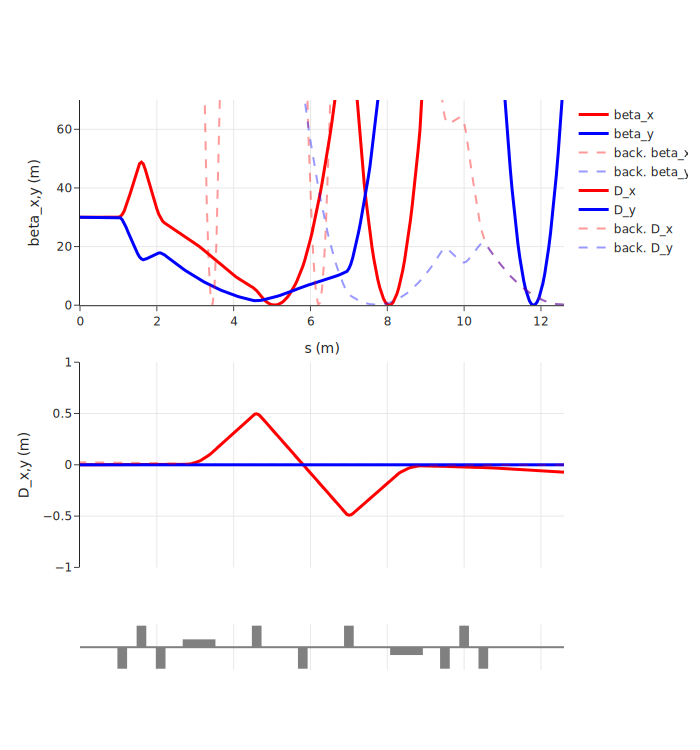

In [23]:
fw.show(renderer="svg")

In [24]:
sdds2df('parameters2load.sdds')

,ElementName,ElementParameter,ParameterValue,ParameterValueString,ElementType,ElementOccurence,ElementGroup
0,QDOGF,K1,7.86,NaN,QUAD,1,NaN
1,Q60,K1,-4.60,NaN,QUAD,1,NaN
2,Q50,K1,4.60,NaN,QUAD,1,NaN
3,Q40,K1,-4.68,NaN,QUAD,1,NaN
4,QDOGD,K1,-1.00,NaN,QUAD,1,NaN


Now let us tune the final focusing triplet and the central dogleg quadrupole:

In [25]:
@interact(QDOGD=(-10,0,0.02), Q40=(-10,0,0.02), Q50=(0,15,0.02), Q60=(-10,0,0.02))
def update_parameters(
        QDOGD=element_par("QDOGD","K1"),
        Q40=element_par("Q40","K1"),
        Q50=element_par("Q50","K1"),
        Q60=element_par("Q60","K1") ):
    
    change_par("QDOGD", "K1", QDOGD)
    change_par("Q40", "K1", Q40)
    change_par("Q50", "K1", Q50)
    change_par("Q60", "K1", Q60)
    
    update_figure()

interactive(children=(FloatSlider(value=-1.0, description='QDOGD', max=0.0, min=-10.0, step=0.02), FloatSlider…

In [26]:
fw

FigureWidget({
    'data': [{'line': {'color': 'red', 'width': 3},
              'mode': 'lines',
              'name': 'beta_x',
              'type': 'scatter',
              'uid': 'b78b5544-707a-4178-ba33-ee4041c26445',
              'x': array([ 0.  ,  0.05,  0.1 , ..., 12.5 , 12.55, 12.6 ]),
              'xaxis': 'x',
              'y': array([  30.        ,   30.00008333,   30.00033333, ..., 5305.28612631,
                          5481.01984817, 5659.61686732]),
              'yaxis': 'y'},
             {'line': {'color': 'blue', 'width': 3},
              'mode': 'lines',
              'name': 'beta_y',
              'type': 'scatter',
              'uid': '7133f32e-12f5-41ca-9603-cd409f162d1b',
              'x': array([ 0.  ,  0.05,  0.1 , ..., 12.5 , 12.55, 12.6 ]),
              'xaxis': 'x',
              'y': array([30.        , 30.00008333, 30.00033333, ..., 60.49097462, 69.54518154,
                          79.23066127]),
              'yaxis': 'y'},
             {'l

The widget looks like this:

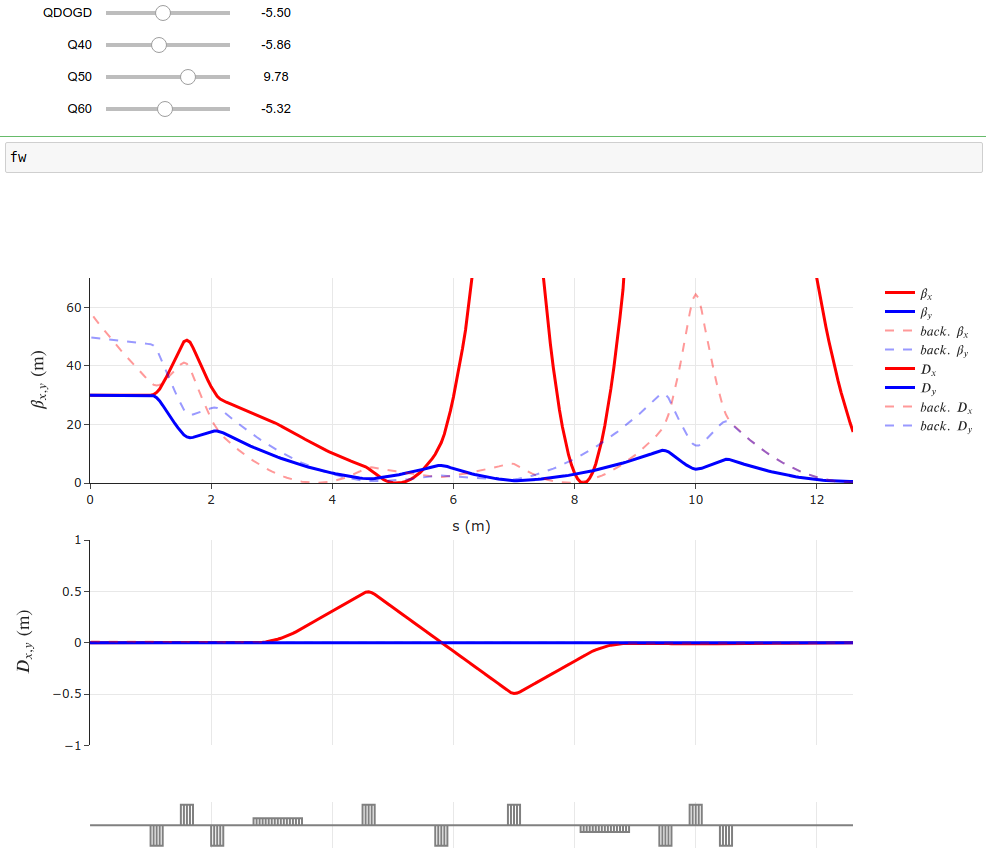

In [27]:
assert False, "breakpoint"

AssertionError: breakpoint

In [ ]:
fw.show(renderer="svg")

Now we can finally tune the first quadrupole triplet:

In [ ]:
@interact(Q10=(-10,0,0.01), Q20=(0,15,0.01), Q30=(-10,0,0.01))
def update_parameters(
        Q10=element_par("Q10","K1"),
        Q20=element_par("Q20","K1"),
        Q30=element_par("Q30","K1") ):
    
    change_par("Q10", "K1", Q10)
    change_par("Q20", "K1", Q20)
    change_par("Q30", "K1", Q30)
    
    update_figure()

In [ ]:
fw

Resulting parameters are saved in the parameters2load.sdds:

In [28]:
sdds2df('parameters2load.sdds')

,ElementName,ElementParameter,ParameterValue,ParameterValueString,ElementType,ElementOccurence,ElementGroup
0,Q60,K1,-4.60,NaN,QUAD,1,NaN
1,Q50,K1,4.60,NaN,QUAD,1,NaN
2,Q40,K1,-4.68,NaN,QUAD,1,NaN
3,QDOGD,K1,-1.00,NaN,QUAD,1,NaN
4,QDOGF,K1,7.86,NaN,QUAD,1,NaN


In [ ]:
fw.show(renderer="svg")

In [ ]:
%load_ext watermark

In [ ]:
%watermark --python --date --iversions --machine

In [30]:
!jupyter nbconvert --to HTML twiss_interact.ipynb

[NbConvertApp] Converting notebook twiss_interact.ipynb to HTML
[NbConvertApp] WARNING | Alternative text is missing on 2 image(s).
[NbConvertApp] Writing 544405 bytes to twiss_interact.html


In [ ]:
pwd

In [ ]:
ls -h -all